In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out)) 
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

In [4]:
class VAE(object):
    def __init__(self, dim_input, dim_latent, hu_encoder, hu_decoder, batch_size, learning_rate, LB):
        self.dim_input = dim_input
        self.dim_latent = dim_latent
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, dim_input])

        # Encoder
        self.z_mean, self.z_log_sigma_sq = self._encoder(dim_input, dim_latent, hu_encoder)
        
        # Latent Z
        eps = tf.random_normal((batch_size, dim_latent), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Decoder
        self.x_reconstr_mean = self._decoder(dim_input, dim_latent, hu_decoder)
        
        # Optimizer
        self._optimizer(learning_rate, LB)
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
                       
    def _encoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_input, n_hidden))
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_mu_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_mu_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        out_sigma_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_sigma_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.x, hidden_w), hidden_b))
        z_mean = tf.add(tf.matmul(hidden_layer, out_mu_w), out_mu_b)
        z_log_sigma_sq = tf.add(tf.matmul(hidden_layer, out_sigma_w), out_sigma_b)
        return z_mean, z_log_sigma_sq

    def _decoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_latent, n_hidden))
        self.hidden_weights = hidden_w
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_w = tf.Variable(xavier_init(n_hidden, dim_input)) 
        out_b = tf.Variable(tf.zeros([dim_input], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.z, hidden_w), hidden_b))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(hidden_layer, out_w), out_b))
        return x_reconstr_mean
    
    def _optimizer(self, learning_rate, LB):
        
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss =  -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)

        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                       - tf.square(self.z_mean) 
                                       - tf.exp(self.z_log_sigma_sq), 1)
        self.cost_lb = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        
        #prob of producing this z from prior * prob of getting back x with the decoder
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        #sqrt(1/(2*pi*sigma^2)) exp(-(x-mu)^2/(2*sigma^2))
        prior = tf.contrib.distributions.Normal(0., 1.)
        prior_loss = -tf.reduce_sum(prior.log_pdf(self.z), 1) 
        # prob oof producing this z from x
        z_dist = tf.contrib.distributions.Normal(self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)))
        latent_loss = tf.reduce_sum(z_dist.log_pdf(self.z), 1)
        self.cost_la = tf.reduce_mean(reconstr_loss + prior_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        
        if (LB):
            self.cost = self.cost_lb
        else:
            self.cost = self.cost_la
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def get_cost(self, X):
        cost = self.sess.run(self.cost, feed_dict={self.x: X})
        return cost
    
    def get_weights(self):
        weights = self.sess.run(self.hidden_weights)
        return weights
    
    def get_cost_la(self, X):
        cost = self.sess.run(self.cost_la, feed_dict={self.x: X})
        return cost
    
    def get_cost_lb(self, X):
        cost = self.sess.run(self.cost_lb, feed_dict={self.x: X})
        return cost
    
    def encode_mean(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def encode_variational(self, X):
        return self.sess.run(self.z, feed_dict={self.x: X})
    
    def generate_prior(self):
        z_mu = np.random.normal(self.dim_latent)
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    
    def generate_z(self, z_mu):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [5]:
def train_model(data, epoch, latent_dim, hidden_units, batch_size, learning_rate, LB):
    input_dim = data.train.images.shape[1]
    model = VAE(input_dim, latent_dim, hidden_units, hidden_units, batch_size, learning_rate, LB)
    training_costs = []
    test_costs = []
    for e in range(epoch):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch, _ = data.train.next_batch(batch_size)

            # Fit training using batch data
            cost = model.partial_fit(batch)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if (e % 1 == 0):
            print("Epoch:", '%04d' % (e+1), "cost=", "{:.9f}".format(avg_cost))
        
        training_cost = 0.
        test_cost = 0.
        for i in range(0, 100):
            batch, _ = data.train.next_batch(batch_size)
            training_cost += model.get_cost(batch) / 100.
            batch, _ = data.test.next_batch(batch_size)
            test_cost += model.get_cost(batch) / 100.
        training_costs.append(training_cost)
        test_costs.append(test_cost)
    return model, training_costs, test_costs

In [6]:
model_2, lb_training_costs, lb_test_costs = train_model(mnist, 80, 2, 500, 100, 0.001, True)    
model_20, lb_training_costs, lb_test_costs = train_model(mnist, 180, 20, 500, 100, 0.001, True)   
model_20_la, la_training_costs, la_test_costs = train_model(mnist, 180, 20, 500, 100, 0.001, False)   

Epoch: 0001 cost= 192.186692671
Epoch: 0002 cost= 177.481055381
Epoch: 0003 cost= 174.285139549
Epoch: 0004 cost= 171.625551980
Epoch: 0005 cost= 169.311424255
Epoch: 0006 cost= 168.998761597
Epoch: 0007 cost= 168.377726551
Epoch: 0008 cost= 168.369629045
Epoch: 0009 cost= 167.644886225
Epoch: 0010 cost= 167.052972246
Epoch: 0011 cost= 166.886761780
Epoch: 0012 cost= 166.365516135
Epoch: 0013 cost= 165.771882241
Epoch: 0014 cost= 165.402771357
Epoch: 0015 cost= 164.752918202
Epoch: 0016 cost= 164.318829762
Epoch: 0017 cost= 163.744441279
Epoch: 0018 cost= 163.143266602
Epoch: 0019 cost= 162.748353188
Epoch: 0020 cost= 162.136541249
Epoch: 0021 cost= 161.447375183
Epoch: 0022 cost= 161.235267473
Epoch: 0023 cost= 160.518394692
Epoch: 0024 cost= 159.952866932
Epoch: 0025 cost= 159.723693792
Epoch: 0026 cost= 159.234545566
Epoch: 0027 cost= 158.486696306
Epoch: 0028 cost= 158.371288258
Epoch: 0029 cost= 157.887212441
Epoch: 0030 cost= 157.919756165
Epoch: 0031 cost= 157.673890547
Epoch: 0

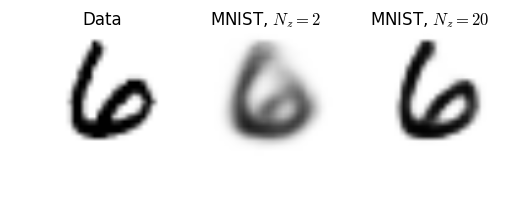

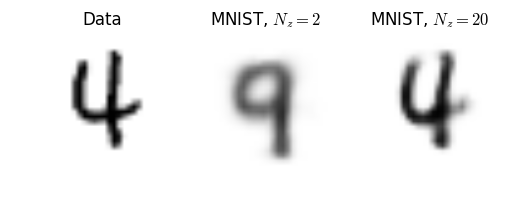

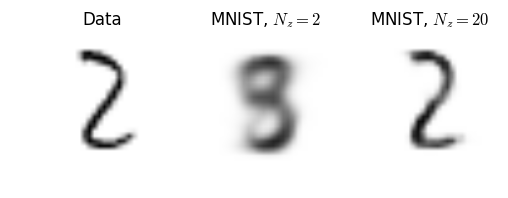

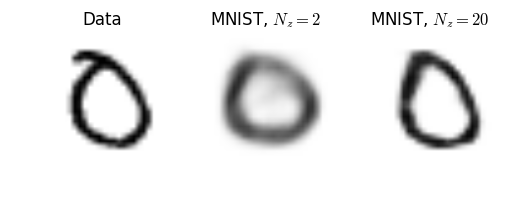

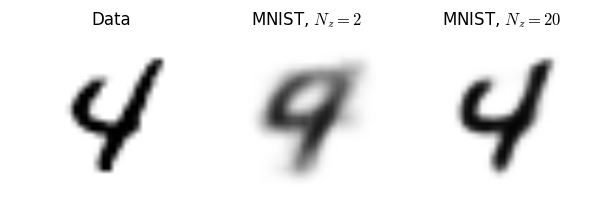

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x_sample = mnist.test.next_batch(100)[0]
x_reconstruct_20 = model_20.reconstruct(x_sample)
x_reconstruct_2 = model_2.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(1-x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Data")
    plt.axis('off')
    #plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(1-x_reconstruct_2[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title(r'Reconstruction $N_z = 2$')
    plt.axis('off')
    #plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(1-x_reconstruct_20[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title(r'Reconstruction $N_z = 20$')
    plt.axis('off')
    plt.savefig('recon_' + str(i) + '.pdf')
plt.tight_layout()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

weights_20d = model_3d_lb.get_weights()
l2_weights_20d = np.mean(np.abs(weights_20d)**2, axis=1)

plt.hist(l2_weights_20d, bins=np.logspace(-5, 0, 8))
plt.gca().set_xscale("log")
plt.title(r'Contribution of dimensions, $N_z = 20$')
plt.xlabel('Squares of weights of dimensions')
plt.ylabel('Number of dimensions')
plt.ylim(0, 300)
plt.xlim(10**-4, 1)
plt.savefig('regul_20d.pdf')
plt.show()

weights_400d = model_400d_lb.get_weights()
l2_weights_400d = np.mean(np.abs(weights_400d)**2, axis=1)
plt.figure()
plt.hist(l2_weights_400d, bins=np.logspace(-4, 0, 8))
plt.title(r'Contribution of dimensions, $N_z = 400$')
plt.xlabel('Squares of weights of dimensions')
plt.ylabel('Number of dimensions')
plt.gca().set_xscale("log")
plt.xlim(10**-4, 1)
plt.ylim(0, 300)
plt.savefig('regul_400d.pdf')
plt.show()


NameError: name 'model_3d_lb' is not defined

5.18738580584 [1, 1, 1, 2, 2, 3, 5, 6, 8, 11, 15, 20, 26, 34, 45, 60, 78, 103, 136, 179]


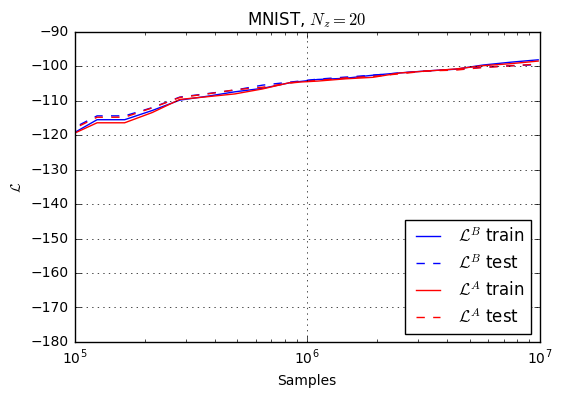

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.logspace(0., np.log10(179.), num=20)

print( np.log(179.), [int(i) for i in x])

plt.figure()
plt.semilogx([i * n_samples + 1 for i in x], [-lb_training_costs[int(i)] for i in x], 'b-', label=r'$\mathcal{L}^B$ train')
plt.semilogx([i * n_samples + 1 for i in x], [-lb_test_costs[int(i)] for i in x], 'b--', label=r'$\mathcal{L}^B$ test')
plt.semilogx([i * n_samples + 1 for i in x], [-la_training_costs[int(i)] for i in x], 'r-', label=r'$\mathcal{L}^A$ train')
plt.semilogx([i * n_samples + 1 for i in x], [-la_test_costs[int(i)] for i in x], 'r--', label=r'$\mathcal{L}^A$ test')
plt.title(r'MNIST, $N_z = 20$')
plt.ylabel(r'$\mathcal{L}$')
plt.ylim(-180, -90)
plt.xlim(100000, 10000000)
plt.xlabel('Samples')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid(True)
plt.legend(loc=4)
plt.savefig('lalb_d3.pdf')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*model_2d.batch_size)
        x_mean = model_2d.generate_z(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()